<a href="https://colab.research.google.com/github/samsyano/Transfer-Learning-/blob/main/Transfer_Learning_Food_Classification_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-10 03:38:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-10 03:38:29 (109 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip


--2023-08-10 18:34:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.181.128, 64.233.182.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   146MB/s    in 11s     

2023-08-10 18:34:16 (145 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, calculate_results

In [ ]:
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
# Check image classes
# walk_through_dir("101_food_classes_10_percent")

In [ ]:
# Create training and test directory paths

train_dir = "101_food_classes_10_percent/train"
test_dir= "101_food_classes_10_percent/test"

In [ ]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_all_10percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes data

Steps
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layer) functional EfficientNetB0 backboned-model
* Compile model
* Feature extraction for 5 full passes (5 epochson the train dataset and validate on 15% of data )

In [ ]:
# Create checkpoint callback
checkpoint_path =  "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True,
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incoporate it right into the model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [ ]:
# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.), rescale inputs of images btw 0 & 1 required for models like ResNet
], name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) #augment images only during training phase
x = base_model(x, training=False) # put the base model in inference mode so weight need to stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [ ]:

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10percent,
                                           epochs=5, #fit for 5 epochs to keep experiment quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), #validate on only 15% of test data
                                           callbacks=[checkpoint_callback]
                                           )

Epoch 1/5
237/237 [==============================] - 120s 436ms/step - loss: 3.3763 - accuracy: 0.2754 - val_loss: 2.4745 - val_accuracy: 0.4563
Epoch 2/5
237/237 [==============================] - 77s 320ms/step - loss: 2.2046 - accuracy: 0.4925 - val_loss: 2.0652 - val_accuracy: 0.5008
Epoch 3/5
237/237 [==============================] - 69s 286ms/step - loss: 1.8298 - accuracy: 0.5708 - val_loss: 1.8786 - val_accuracy: 0.5381
Epoch 4/5
237/237 [==============================] - 63s 266ms/step - loss: 1.6150 - accuracy: 0.6008 - val_loss: 1.7908 - val_accuracy: 0.5506
Epoch 5/5
237/237 [==============================] - 59s 246ms/step - loss: 1.4479 - accuracy: 0.6457 - val_loss: 1.7170 - val_accuracy: 0.5551


In [ ]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 66s 83ms/step - loss: 1.5771 - accuracy: 0.5857


[1.5770909786224365, 0.585663378238678]

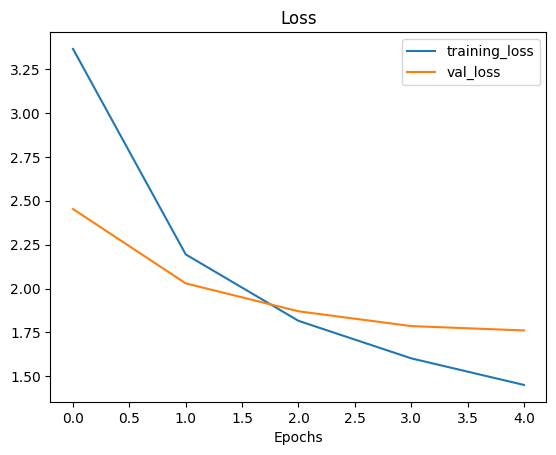

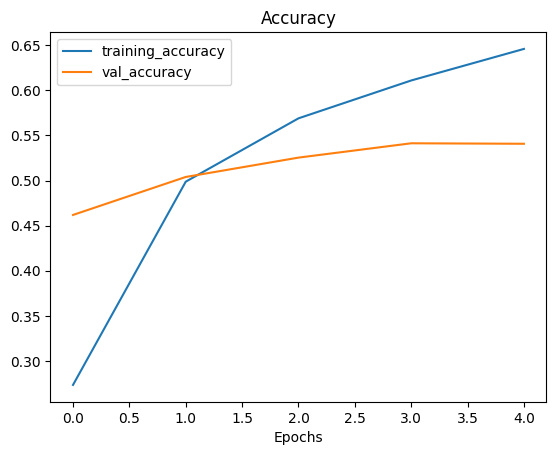

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

### Build model with 5 unfreezed layers

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze all layers except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False


In [ ]:
# Recompile model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check the trainable layers
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10

# Fine tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]
                                                     )

Epoch 5/10
237/237 [==============================] - 70s 252ms/step - loss: 1.2051 - accuracy: 0.6826 - val_loss: 1.8182 - val_accuracy: 0.5267
Epoch 6/10
237/237 [==============================] - 55s 229ms/step - loss: 1.0979 - accuracy: 0.7083 - val_loss: 1.7942 - val_accuracy: 0.5339
Epoch 7/10
237/237 [==============================] - 49s 204ms/step - loss: 0.9414 - accuracy: 0.7480 - val_loss: 1.8545 - val_accuracy: 0.5260
Epoch 9/10
237/237 [==============================] - 46s 193ms/step - loss: 0.8868 - accuracy: 0.7636 - val_loss: 1.8095 - val_accuracy: 0.5299
Epoch 10/10
237/237 [==============================] - 48s 199ms/step - loss: 0.8286 - accuracy: 0.7787 - val_loss: 1.8381 - val_accuracy: 0.5220


In [ ]:
# Evaluate on the whole test dataset
all_classes_10p_fine_tune_results = model.evaluate(test_data)
all_classes_10p_fine_tune_results

790/790 [==============================] - 73s 92ms/step - loss: 1.5170 - accuracy: 0.5990


[1.5170036554336548, 0.5989702939987183]

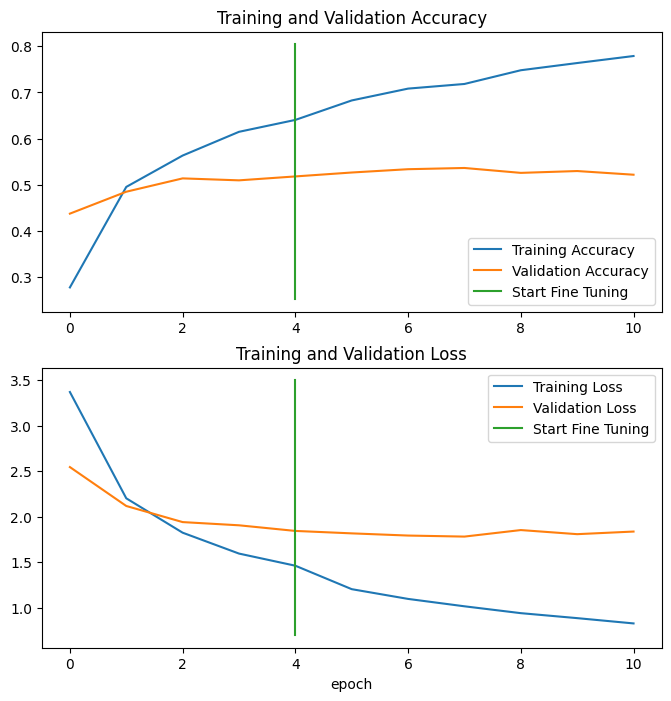

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune, initial_epochs=5)

### Saving and Loading model

In [ ]:
# Save our fine-tuning Model

model.save("drive/MyDrive/Tensorflow_food_class_models")

**Note:** *model.save does not work for TF2.10 and tf.keras.applications.efficientnet.EfficientNetB0. only works after downgrading tf version 2.9 and below or using a differrent model*

In [ ]:
# evaluate loaded model and compare performance to pre-saved model
# loaded_model_results = loaded_model.evaluate(test data)
# loaded_model_results

### Download a pretrained model to evaluate and make prediction

In [ ]:
import tensorflow as tf

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-08-10 04:41:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 142.250.107.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  85.5MB/s    in 0.5s    

2023-08-10 04:41:35 (85.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load the saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (we just downloaded)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 67s 81ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

### Make predictions with our trained model

In [ ]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 78s 95ms/step


In [ ]:
# How many predictions are there??
len(preds_probs)

25250

In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
# Lets see what the first predictions looks like
preds_probs[:10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [ ]:
# What does the first prediction probability array looks like
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e